In [2]:
 !cp -r ../input/custom-augment2/autoaugment.py ./

In [3]:
import numpy as np 
import pandas as pd 

import os
from glob import glob

from keras.applications import ResNet50

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import cv2 as cv

#image preprocessing libraries
import skimage
from skimage import io, img_as_float
from skimage.filters import unsharp_mask
from skimage.transform import resize
from skimage.color import rgb2gray

import autoaugment

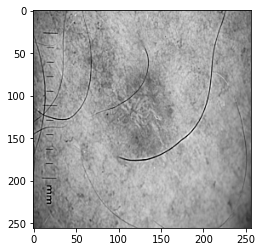

In [4]:
#path leading to training images
training_path = '../input/siim-isic-melanoma-classification/jpeg/train/' 
#generate a list of image names
training_image_names = [name for name in os.listdir(training_path)]

#testing the image loading and preporcessing
test_image = io.imread(training_path+training_image_names[1], as_gray=True)
test_image = resize(test_image, (256, 256))
test_image = unsharp_mask(test_image, radius=1, amount=3)
plt.imshow(test_image, cmap=plt.cm.gray)

In [5]:
## load training csv
training_labels = pd.read_csv('../input/siim-isic-melanoma-classification/train.csv', sep=',')

#the train.csv holds more information than we need, thus we extract only the needed columns
training_labels = training_labels[['image_name', 'target']]

# the targets are: 0 = benign, 1 = malignant
#training labels that have a target of 0
training_labels_0 = pd.DataFrame(training_labels.loc[training_labels['target'] == 0])
#training labels that have a target of 1 
training_labels_1 = pd.DataFrame(training_labels.loc[training_labels['target'] == 1])
 
#in advance turn both pandas dataframes to numpy arrays, as we need to reshape their values later (a numpy function)
#and because the resnet model only accepts numpy arrays as inputs
training_labels_0 = np.asarray(training_labels_0)
training_labels_1 = np.asarray(training_labels_1)

#the structures of both numpy arrays are as follows:
#training_labels_# [index of the image][0 = name of the image, 1 = the target]

print("labels with a target of 0:",len(training_labels_0))
print("labels with a target of 1:",len(training_labels_1))

labels with a target of 0: 32542
labels with a target of 1: 584


In [6]:
def get_regular(path):
    
    image = io.imread(path)
    image = resize(image, (256,256))
    image = np.reshape(image, (256,256, 1))
    
    return image

In [7]:
from PIL import Image
def get_augmented(path, idx=5):
    
    policy = autoaugment.ImageNetPolicy(idx)

    image = Image.open(path)
    image = image.resize((256,256))
    image = image.convert('L')
#     image = Image.gray(image)
    
    augmented = policy(image)
    augmented = np.array(augmented)
    augmented = np.reshape(augmented, (256,256,1))
    return augmented

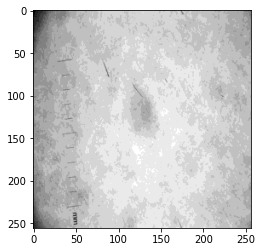

In [20]:

# image = io.imread(training_path+training_image_names[0])
# plt.imshow(image,cmap='gray')
image = get_augmented(training_path+training_image_names[0], 0)
plt.imshow(image, cmap='gray')

In [10]:
#Choose how many sample would you like
data_size = 584*2

#prepare numpy arrays, where the loaded images and labels will be stored
# training_images = np.zeros((data_size, 256, 256, 1))
training_augmented1 = np.zeros((data_size, 256, 256, 1))
training_augmented2 = np.zeros((data_size, 256, 256, 1))
training_augmented3 = np.zeros((data_size, 256, 256, 1))
training_augmented4 = np.zeros((data_size, 256, 256, 1))
training_augmented5 = np.zeros((data_size, 256, 256, 1))


training_labels = np.zeros((data_size))


In [11]:
for i in range(0, len(training_labels_1)):
    #load an image
    path = training_path+training_labels_1[i][0]+'.jpg'
    
    augmented = get_augmented(path, 0)
    training_augmented1[i] = augmented
    
    augmented = get_augmented(path, 1)
    training_augmented2[i] = augmented
    
    augmented = get_augmented(path, 2)
    training_augmented3[i] = augmented
    
    augmented = get_augmented(path, 3)
    training_augmented4[i] = augmented
    
    augmented = get_augmented(path, 4)
    training_augmented5[i] = augmented
    
    
    
    #storing the target label
    training_labels[i] = training_labels_1[i][1]
    
    if(i%200==0):
        #simple way of informing about the progress
        print(i, training_labels_1[i][0], "uploaded")
        
#same exact steps are applied to images, with a target of 0
for i in range(len(training_labels_1), data_size):
    
    path = training_path+training_labels_0[i][0]+'.jpg'
    
    augmented = get_augmented(path, 0)
    training_augmented1[i] = augmented
    
    augmented = get_augmented(path, 1)
    training_augmented2[i] = augmented
    
    augmented = get_augmented(path, 2)
    training_augmented3[i] = augmented
    
    augmented = get_augmented(path, 3)
    training_augmented4[i] = augmented
    
    augmented = get_augmented(path, 4)
    training_augmented5[i] = augmented
    
    
    #storing the image
    training_labels[i] = training_labels_0[i][1]
    if(i%200==0):
        print(i ,training_labels_0[i][0], "uploaded")
    

0 ISIC_0149568 uploaded
200 ISIC_3435596 uploaded
400 ISIC_7070020 uploaded
600 ISIC_0287804 uploaded
800 ISIC_0349484 uploaded
1000 ISIC_0412659 uploaded


In [13]:
# print(training_images.shape)
# print(training_labels.shape)
#split the data into training and testing

xtr1, xte1, ytr1, yte1 = train_test_split(training_augmented1, training_labels, train_size=0.8, random_state=42)
xtr2, xte2, ytr2, yte2 = train_test_split(training_augmented2, training_labels, train_size=0.8, random_state=42)
xtr3, xte3, ytr3, yte3 = train_test_split(training_augmented3, training_labels, train_size=0.8, random_state=42)
xtr4, xte4, ytr4, yte4 = train_test_split(training_augmented4, training_labels, train_size=0.8, random_state=42)
xtr5, xte5, ytr5, yte5 = train_test_split(training_augmented5, training_labels, train_size=0.8, random_state=42)
# xtr_segment, xte_segment, ytr_segment, yte_segment = train_test_split(training_segments, training_labels, train_size=0.8, random_state=42)


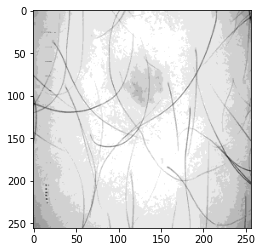

In [25]:
plt.imshow(xtr1[5], cmap="gray")
# print(ytr_regular[1])

In [26]:
yte_regular[np.where(yte_regular==0)].shape

(111,)

In [14]:
#The resnet model.
#For some reason the model states that the amount of classes in our database is 1 
#No weights, because imagenet is not useful for our purpose and i'm not aware of other weights we can use
#The input shape follows the shape of the images
#Sigmoid, because our classes range from 0 and 1 and it's recommended for binary categorization
model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')

#Binary crossentropy because our classes range from 0 and 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])

In [15]:
def traintest(model, x_train, y_train, x_test, y_test, eps=50):
    model.fit(x_train,y_train, batch_size=8, epochs=eps, validation_split=0.1)
    evaluation = model.evaluate(x_test,y_test)
    return evaluation

In [17]:
model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
print(traintest(model, xtr1, ytr1, xte1, yte1))

model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
print(traintest(model, xtr2, ytr2, xte2, yte2))

model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
print(traintest(model, xtr3, ytr3, xte3, yte3))

model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
print(traintest(model, xtr4, ytr4, xte4, yte4))

model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])
print(traintest(model, xtr5, ytr5, xte5, yte5))

Epoch 1/50
105/105 [==============================] - 14s 90ms/step - loss: 1.2344 - accuracy: 0.5705 - recall: 0.5807 - precision: 0.5635 - val_loss: 3.7565 - val_accuracy: 0.3723 - val_recall: 0.3061 - val_precision: 0.3750
Epoch 2/50
105/105 [==============================] - 8s 76ms/step - loss: 0.6655 - accuracy: 0.6609 - recall: 0.6574 - precision: 0.6581 - val_loss: 4.3400 - val_accuracy: 0.4787 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/50
105/105 [==============================] - 8s 76ms/step - loss: 0.6930 - accuracy: 0.6566 - recall: 0.6829 - precision: 0.6286 - val_loss: 1.3080 - val_accuracy: 0.3617 - val_recall: 0.1429 - val_precision: 0.2800
Epoch 4/50
105/105 [==============================] - 8s 77ms/step - loss: 0.6127 - accuracy: 0.6666 - recall: 0.7548 - precision: 0.6454 - val_loss: 1.0465 - val_accuracy: 0.4362 - val_recall: 0.2041 - val_precision: 0.4167
Epoch 5/50
105/105 [==============================] - 8s 76ms/step - loss: 0.5968 - accurac

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

In [ ]:
model.fit(xtr1,ytr1, batch_size=8, epochs=50, validation_split=0.1)

In [19]:
model.evaluate(xte1,yte1)

8/8 [==============================] - 1s 84ms/step - loss: 0.5758 - accuracy: 0.6581 - recall: 0.5203 - precision: 0.7529: 0s - loss: 0.5697 - accuracy: 0.6652 - recall: 0.5304 - precision: 0.74


[0.5758087038993835,
 0.6581196784973145,
 0.5203251838684082,
 0.7529411911964417]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Recall', 'Precision'])

In [ ]:
model.fit(xtr2,ytr2, batch_size=8, epochs=50, validation_split=0.1)

In [34]:
model.evaluate(xte2,yte2)

8/8 [==============================] - 1s 69ms/step - loss: 0.6743 - accuracy: 0.5598 - recall: 0.4472 - precision: 0.6111


[0.6743321418762207, 0.55982905626297, 0.4471544623374939, 0.6111111044883728]

In [ ]:
#prepare numpy arrays, where the loaded images and labels will be stored
training_images_noseg = np.zeros((data_size, 256, 256, 1))
training_labels_noseg = np.zeros((data_size))

for i in range(0, len(training_labels_1)):
    #load an image
    image = cv.imread(training_path+training_labels_1[i][0]+'.jpg')
    image = preprocess(image)
#     image = get_segment(training_path+training_labels_1[i][0]+'.jpg')
    #storing the image
    training_images_noseg[i] = image
    #storing the target label
    training_labels_noseg[i] = training_labels_1[i][1]
    if(i%200==0):
        #simple way of informing about the progress
        print(i, training_labels_1[i][0], "uploaded")
        
#same exact steps are applied to images, with a target of 0
for i in range(len(training_labels_1), data_size):
    
    image = cv.imread(training_path+training_labels_0[i][0]+'.jpg')
    image = preprocess(image)
    
    #storing the image
    training_images_noseg[i] = image
    #storing the image
    training_labels_noseg[i] = training_labels_0[i][1]
    if(i%200==0):
        print(i ,training_labels_0[i][0], "uploaded")
        
print(training_images.shape)
print(training_labels.shape)
#split the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(training_images, training_labels, train_size=0.8, random_state=42)

print(x_train.shape)
print(x_test.shape)

#The resnet model.
#For some reason the model states that the amount of classes in our database is 1 
#No weights, because imagenet is not useful for our purpose and i'm not aware of other weights we can use
#The input shape follows the shape of the images
#Sigmoid, because our classes range from 0 and 1 and it's recommended for binary categorization
model = ResNet50(classes=1, weights=None, input_shape=(256,256,1), classifier_activation='sigmoid')

#Binary crossentropy because our classes range from 0 and 1
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(x_train,y_train, batch_size=8, epochs=50, validation_split=0.1)

In [ ]:
model.evaluate(x_test,y_test)

In [ ]:
print(y_test[np.where(y_test==0)].shape[0])
print(y_test[np.where(y_test==1)].shape)


In [ ]:
np.savetxt('./test.csv', training_images.reshape((10,512*512*1)), delimiter=', ')
np.savetxt('./testlabels.csv', training_labels, delimiter=', ')

<a href="./test.csv"> Download File </a>
<a href="../input/siim-isic-melanoma-classification/jpeg/train/ISIC_0015719.jpg"> Download Image </a>

In [12]:
def get_segment(path, output="./"):
    img = cv.imread(path)
    filename_w_ext = os.path.basename(path)
    filename, file_extension = os.path.splitext(filename_w_ext)
#     print(filename)

    img = cv.resize(img, (256,256), interpolation=cv.INTER_AREA)
    median = cv.medianBlur(img,5) # Apply Median filter

    Z = median.reshape((-1,3))
    Z = np.float32(Z)

    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 8
    ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    kmeans_img = res.reshape((img.shape))


    clahe = cv.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    hsv = cv.cvtColor(kmeans_img, cv.COLOR_BGR2HSV)# convert from BGR to HSV color space

    h, s, v = cv.split(hsv)  # split on 3 different channels
    #apply CLAHE to the L-channel
    h1 = clahe.apply(h)
    s1 = clahe.apply(s)
    v1 = clahe.apply(v)

    lab = cv.merge((h1,s1,v1))  # merge channels

    enhanced_img = cv.cvtColor(lab, cv.COLOR_LAB2RGB)  # convert from LAB to BGR
#     enhanced_img = cv.cvtColor(enhanced_img, cv.COLOR_RGB2GRAY)
    enhanced_img = np.reshape(enhanced_img, (256,256,3))
    
    return enhanced_img
#     hsv = cv.cvtColor(enhanced_img, cv.COLOR_BGR2HSV)

#     lower_green = np.array([50,100,100])
#     upper_green = np.array([100,255,255])
#     mask_g = cv.inRange(hsv, lower_green, upper_green)

#     _, inv_mask = cv.threshold(mask_g,127,255,cv.THRESH_BINARY_INV)
#     res = cv.bitwise_and(img,img, mask= mask_g)

#     mask = np.zeros(img.shape[:2],np.uint8)
#     bck_model = np.zeros((1,65),np.float64)
#     frg_model = np.zeros((1,65),np.float64)

#     try:
#         if (np.sum(inv_mask) < (256*256*255)/2):
#     #         print("not using rectangle")
#             newmask = inv_mask
#             mask[newmask == 0] = 0
#             mask[newmask == 255] = 1
#             cv.grabCut(img,mask,None,bck_model,frg_model,5,cv.GC_INIT_WITH_MASK)
#             mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#             segment_img = img*mask2[:,:,np.newaxis]


#         else:
#     #         print("using rectangle")
#             s = (img.shape[0] / 10, img.shape[1] / 10)
#             rect = np.array((s[0], s[1], img.shape[0] - (3/10) * s[0], img.shape[1] - s[1])).astype("uint8")
#             cv.grabCut(lab,mask,rect,bck_model,frg_model,10,cv.GC_INIT_WITH_RECT)
#             mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
#             segment_img= img*mask2[:,:,np.newaxis]
    
#     except:
#         segment_img = img.copy()
        
#     segment_img = cv.cvtColor(segment_img, cv.COLOR_RGB2GRAY)
#     segment_img = np.reshape(segment_img, (256,256,1))
# #     cv.imwrite(os.path.join(output, filename+".jpg"), segment_img)
#     return segment_img

In [ ]:
img = cv.imread(training_path+"ISIC_1620401.jpg")
img = cv.resize(img, (256,256), interpolation=cv.INTER_AREA)
median = cv.medianBlur(img,5) # Apply Median filter

Z = median.reshape((-1,3))
Z = np.float32(Z)

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 8
ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
kmeans_img = res.reshape((img.shape))


clahe = cv.createCLAHE(clipLimit=3., tileGridSize=(8,8))

hsv = cv.cvtColor(kmeans_img, cv.COLOR_BGR2HSV)# convert from BGR to HSV color space

h, s, v = cv.split(hsv)  # split on 3 different channels
#apply CLAHE to the L-channel
h1 = clahe.apply(h)
s1 = clahe.apply(s)
v1 = clahe.apply(v)

lab = cv.merge((h1,s1,v1))  # merge channels

enhanced_img = cv.cvtColor(lab, cv.COLOR_LAB2BGR)  # convert from LAB to BGR


hsv = cv.cvtColor(enhanced_img, cv.COLOR_BGR2HSV)

lower_green = np.array([50,100,100])
upper_green = np.array([100,255,255])
mask_g = cv.inRange(enhanced_img, lower_green, upper_green)

_, inv_mask = cv.threshold(mask_g,0,255,cv.THRESH_BINARY_INV)
res = cv.bitwise_and(img,img, mask= mask_g)

plt.imshow(inv_mask)